In [8]:
# Import libraries
from plantcv import plantcv as pcv 
from PIL import Image
import glob
from itertools import product
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
from skimage.filters import threshold_li
from skimage import filters as filters


In [9]:
import os
class options:
    def __init__(self):
        self.image = "/home/grads/y/yashzambre/Desktop/YASH/plantpattern/AgriLife_Dataset-20230206T185531Z-002/AgriLife_Dataset/Recording_2022-03-03_18_16_16/TIFF/MASTER 220003/Image_000042.tif"
        self.debug = "plot"
        self.tmp_dir = "./home/grads/y/yashzambre/Desktop/YASH/plantpattern"
        self.result = os.path.join(self.tmp_dir, "try2.txt")
        self.writeimg= False 
        self.outdir = "./home/grads/y/yashzambre/Desktop/YASH/plantpattern"
        os.makedirs(self.tmp_dir, exist_ok=True)

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

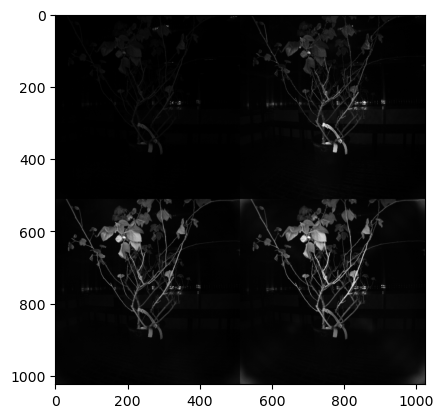

In [10]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

In [11]:
def tile(img, d=2):
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    img_boxes = []
    for i, j in grid:
        box = (j, i, j+d, i+d)
        img_boxes.append(box)
        
    return img_boxes

In [12]:
img_dir = '/home/grads/y/yashzambre/Desktop/YASH/plantpattern/AgriLife_Dataset-20230206T185531Z-002/AgriLife_Dataset/Recording_2022-03-03_18_16_16/TIFF/MASTER 220003'
img_index = 3
img_files = []
for file in glob.glob(img_dir + "/*.tif"):
    img_files.append(file)
  
im = Image.open(img_files[img_index])

#Divide image into 4 equal parts (separate channels)
img_size = im.size[0] // 2
img_slices = tile(im, d = img_size)

#Stack channels to generate RGB image
scaler = MinMaxScaler(feature_range=(0, 1))
img_stack = np.zeros((img_size,img_size,len(img_slices)))
i = 0
for box_coords in img_slices:
    temp_img = np.array(im.crop(box_coords))
    #Normalize
    scaler.fit(temp_img)
    temp_img = scaler.transform(temp_img)
    img_stack[:,:,i] = temp_img
    i += 1



In [13]:
from skimage.filters import threshold_li

In [14]:
#Create 4 channel image
red = np.expand_dims(img_stack[:,:,1],axis=-1)
green = np.expand_dims(img_stack[:,:,0],axis=-1)
red_edge = np.expand_dims(img_stack[:,:,2],axis=-1)
NIR = np.expand_dims(img_stack[:,:,-1],axis=-1)
composite_img = np.concatenate((red,green,red_edge,NIR),axis=-1)

#Use pca to reduce vector 
reshaped_composite_img = np.reshape(composite_img,(-1,4))

#Apply PCA
pca = PCA(n_components=1, whiten=True)
gray_vector = pca.fit_transform(reshaped_composite_img)

#Visualize image
gray_img = np.reshape(gray_vector,(512,512))

#Convert to image and resize
#gray_img = Image.fromarray(np.uint8(gray_img)*255).resize((256,256))
#gray_img = np.array(gray_img)


#Normalize and scale between 0 and 255 (inclusive)
scaler.fit(gray_img)
gray_img = scaler.transform(gray_img)

thresh = filters.threshold_otsu(gray_img)
binary = gray_img > thresh

img = binary.astype(int)

In [15]:
# Read image (sometimes you need to run this line twice to see the image) 

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
#img, path, filename = pcv.readimage(filename=args.image)

# Crop the mask 
cropped_mask = img

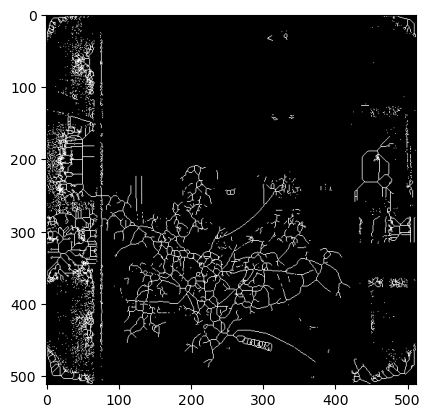

In [16]:
# Skeletonize the mask 
#%matplotlib notebook
# To enable the zoom feature to better see fine lines, uncomment the line above ^^ 

# Inputs:
#   mask = Binary image data
skeleton = pcv.morphology.skeletonize(mask=cropped_mask)

In [9]:
from PIL import Image, ImageFilter
#%pip install ImageFilter
import matplotlib.pyplot as plt

import cv2
import numpy

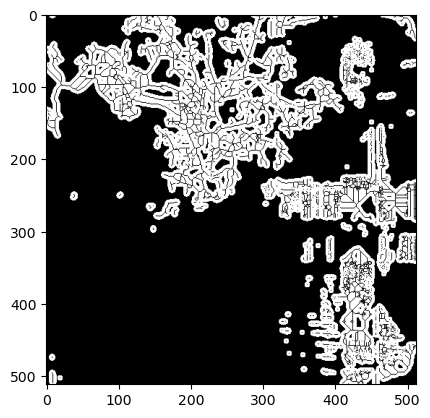

In [10]:
# ImageFilter for using filter() function
th2 = cv2.adaptiveThreshold(skeleton,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
th3 = cv2.adaptiveThreshold(skeleton,10,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

plt.imshow(th2)            
plt.imshow(th3,'binary')  

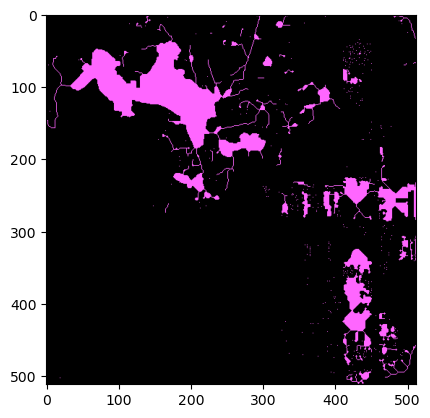

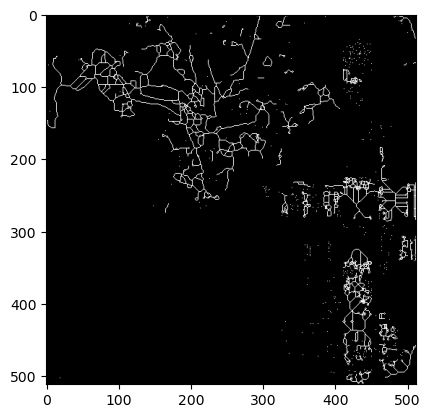

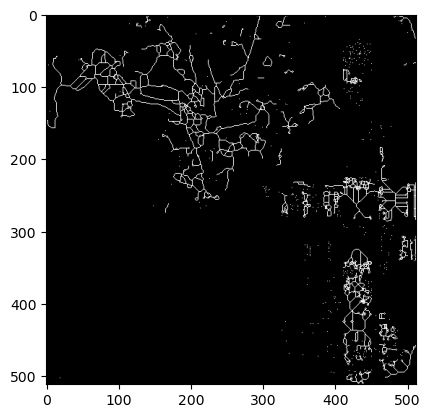

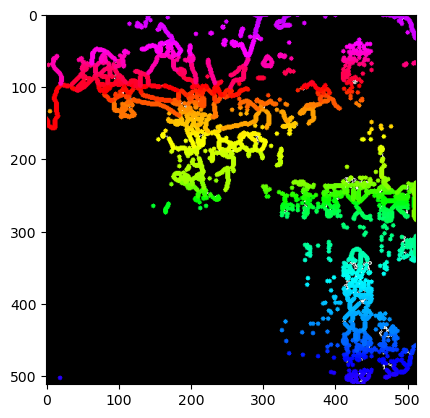

In [11]:
# Prune the skeleton  
# Generally, skeletonized images will have barbs (this image is particularly ideal, 
# that's why it's the example image in the tutorial!), 
# representing the width, that need to get pruned off. 

# Inputs:
#   skel_img = Skeletonized image
#   size     = Size to get pruned off each branch
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
img1, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=70, mask=None)

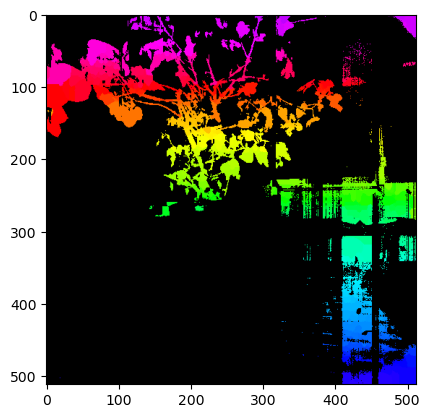

In [12]:
# Fill in segments (also stores out area data)  

# Inputs:
# mask         = Binary image, single channel, object = 1 and background = 0
# objects      = List of contours
# label        = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects, label="default")

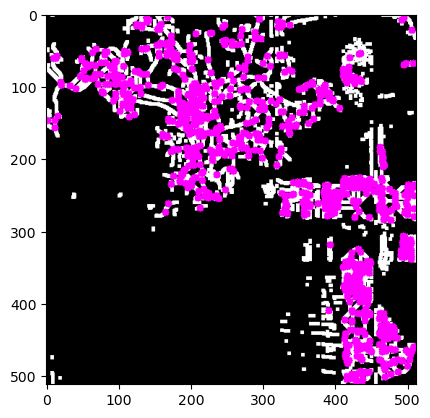

In [13]:
# Identify branch points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton, mask=None, label="default")

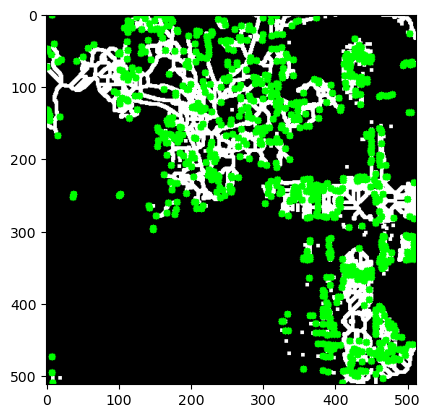

In [14]:
# Identify tip points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug 
#              image will be overlaid on the mask
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, mask=None, label="default")

In [15]:
# Adjust line thickness with the global line thickness parameter (default = 5),
# and provide binary mask of the plant for debugging. NOTE: the objects and
# hierarchies returned will be exactly the same but the debugging image (segmented_img)
# will look different.
pcv.params.line_thickness = 3

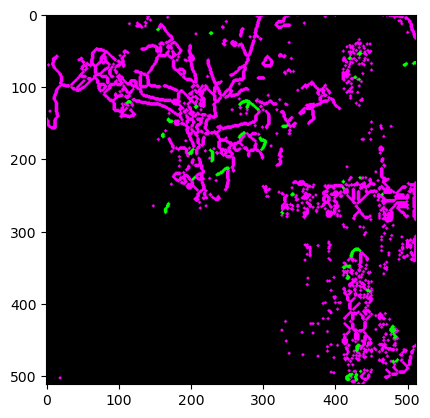

In [16]:
# Sort segments into primary (stem) objects and secondary (leaf) objects. 
# Downstream steps can be performed on just one class of objects at a time, 
# or all objects (output from segment_skeleton) 
  
# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
leaf_obj, stem_obj = pcv.morphology.segment_sort(skel_img=skeleton, 
                                                 objects=edge_objects,
                                                 mask=None)

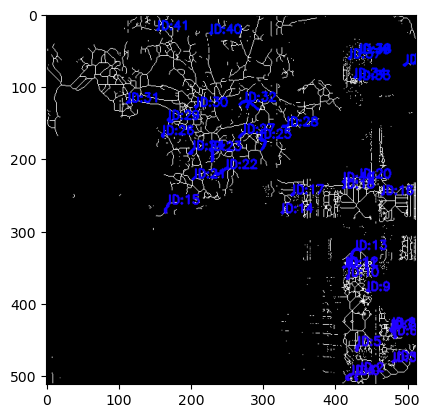

In [17]:
# Identify segments     

# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, 
#               debug image will be overlaid on the mask.
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=None)

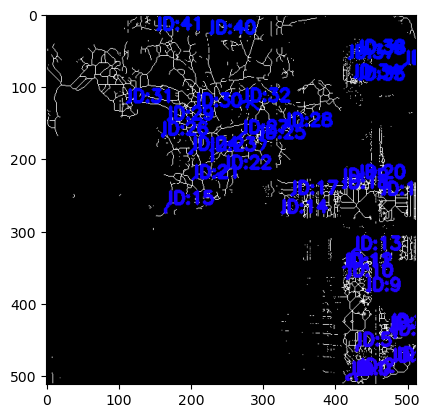

In [18]:
# Similar to line thickness, there are optional text size and text thickness parameters 
# that can be adjusted to better suit images or varying sizes.
pcv.params.text_size=.8 # (default text_size=.55)
pcv.params.text_thickness=3 # (defaul text_thickness=2) 

segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=None)

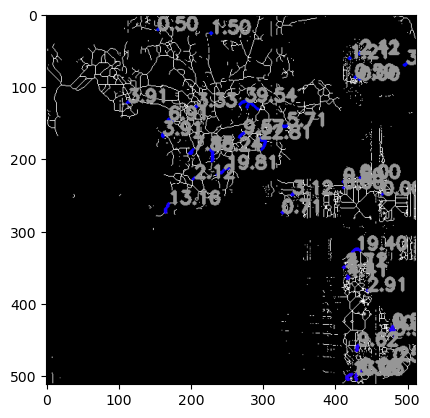

In [19]:
# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
#   label           = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj, label="default")

In [20]:
# Write morphological data to results file

# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)

In [21]:
import plantcv.parallel
import plantcv.utils
plantcv.parallel.process_results(job_dir=args.tmp_dir, json_file="try1.json")
plantcv.utils.json2csv(json_file="try1.json", csv_file="try1")